<div style="background-color:LightBlue; text-align:center; padding:20px;">
    <h2 style="color:black; font-family: Verdana, sans-serif;"><strong>Reinforcement Learning Project - ViZ Doom</strong></h2>
    <p style="font-size: 14px; color: black; font-family: Verdana, sans-serif;"> 
        <table style="margin: auto; border-collapse: collapse; color: black;">
            <tr>
                <th style="border: 0;">Names</th>
                <th style="border: 0;">GitHub Username</th>
            </tr>
            <tr>
                <td style="border: 0;">Rogier Gernaat</td>
                <td style="border: 0;">RogierHHS</td>
            </tr>
            <tr>
                <td style="border: 0;">Daan Eising</td>
                <td style="border: 0;">DaanEising</td>
            </tr>
            <tr>
                <td style="border: 0;">Julia Boschman</td>
                <td style="border: 0;">JuliaBoschman</td>
            </tr>
            <tr>
                <td style="border: 0;">Jort Kankerhoek</td>
                <td style="border: 0;">Homoboi</td>
            </tr>
        </table>
    </p>|
</div>

<div style="display: flex; justify-content: center; align-items: center; margin-top: 10px;">
    <img src="Overige bestanden/Doomski.png/" alt="Doomski.png" style="width: 1000px; height: auto;">
</div>


- ***Docent***: Vikram Radhakrishnan
- ***Datum***: 08-04-2025


---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Inhoudsopgave </strong></h2>
</div>



1. [H1: Inleiding](#1.0)
    - [&sect;1.1: Imports](#1.1)
2. [H2: Use Case](#2.0)
    - [&sect;2.1: Kiezen van Use Case](#2.1)
    - [&sect;2.2: Probleemdefinitie en Doelstelling](#2.2)
3. [H3: Ontwerp en Implementatie van het RL-model](#3.0)
    - [&sect;3.1: Ontwikkelen Baseline strategie](#3.1)
    - [&sect;3.2: Implementeren van een algoritme](#3.2)
    - [&sect;3.3: Experimenteer met hyperparameters](#3.3)
    - [&sect;3.4: Training](#3.4)
4. [H4: Valideer en Vergelijk](#4.0)
    - [&sect;4.1: Vergelijken met minimaal één baseline](#4.1)
    - [&sect;4.2: Analiseren en Visualiseren van Resultaten](#4.2)
6. [H5: Beschrijf je werk (Rapport)](#5.0)
    - [&sect;6.1: Probleemstelling](#5.1)
    - [&sect;6.2: Methodologie](#5.2)
    - [&sect;6.3: Resultaten](#5.3)
    - [&sect;6.4: Reflectie](#5.4)
7. [H6: Literatuurlijst](#6.0)
8. [H7: Beoordelingscriteria](#7.0)



---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong>H1: Inleiding </strong></h2>
</div>

<a name='1.1'></a>
<h3>&sect;1.1: Imports</h3>

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Importeren van de library's</strong>
</div>



In [64]:
#Librarys
import cv2
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Vizdoom
from vizdoom import *
from vizdoom import DoomGame, Mode


#OpenAI Gym
from gym import Env
from gym.spaces import Discrete, Box


<div style="background-color:white; color:black; padding: 10px;">
    <strong>Installeren van de VizDoom omgeving</strong>
</div>

Let op bij het installeren van ViZDoom

Bij het installeren van ViZDoom op Windows liep ik tegen een fout aan: de installatie faalde omdat de `vizdoom` package niet goed overweg kan met recente Python-versies (zoals 3.12 of 3.13). ViZDoom ondersteunt op dit moment alleen Python **tot en met 3.11**, en het bouwen van de package faalt bij nieuwere versies.

In [57]:
!pip install vizdoom

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 70.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 121.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 76.2 MB/s eta 0:00:00


In [3]:
!cd github & git clone https://github.com/mwydmuch/ViZDoom.git

The system cannot find the path specified.
Cloning into 'ViZDoom'...
Updating files:  76% (1580/2057)
Updating files:  77% (1584/2057)
Updating files:  78% (1605/2057)
Updating files:  79% (1626/2057)
Updating files:  80% (1646/2057)
Updating files:  81% (1667/2057)
Updating files:  82% (1687/2057)
Updating files:  83% (1708/2057)
Updating files:  84% (1728/2057)
Updating files:  85% (1749/2057)
Updating files:  86% (1770/2057)
Updating files:  87% (1790/2057)
Updating files:  88% (1811/2057)
Updating files:  89% (1831/2057)
Updating files:  90% (1852/2057)
Updating files:  91% (1872/2057)
Updating files:  92% (1893/2057)
Updating files:  93% (1914/2057)
Updating files:  94% (1934/2057)
Updating files:  95% (1955/2057)
Updating files:  96% (1975/2057)
Updating files:  97% (1996/2057)
Updating files:  98% (2016/2057)
Updating files:  99% (2037/2057)
Updating files: 100% (2057/2057)
Updating files: 100% (2057/2057), done.



---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong>H2: Use Case </strong></h2>
</div>



<a name='2.1'></a>
<h3>&sect;2.1: Kiezen van Use Case</h3>

<a name='2.2'></a>
<h3>&sect;2.2: Probleemdefinitie en Doelstelling</h3>


---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H3: Ontwerp en Implementatie </strong></h2>
</div>

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Testen met basic.was scenario</strong>
</div>

In deze sectie testen we of ViZDoom goed functioneert door het `basic.wad` scenario op te starten. We laten een eenvoudige agent willekeurige acties uitvoeren, zodat we kunnen controleren of de installatie werkt en hoe de omgeving reageert.

---

###  Waar komen de bestanden vandaan?

Wanneer je ViZDoom installeert via pip en de repository op github, worden er automatisch enkele **standaard scenario’s** meegeleverd. Deze scenario's bevatten `.cfg` (configuratie) bestanden en `.wad` (level/map) bestanden, zoals:

- `basic.cfg`: bevat instellingen zoals de tijdslimiet van het spel, welke acties beschikbaar zijn, hoe rewards worden toegekend, enz.
- `basic.wad`: dit is de daadwerkelijke map/omgeving waarin het spel zich afspeelt — in dit geval één kamer met een vijand.

Zorg dat je `basic.cfg` pad goed staat in je project. Meestal zitten deze bestanden in de `ViZDoom/scenarios/` map.

---

###  Wat doet deze test?

De test start het Basic-scenario, voert een willekeurige actie uit in elk timestep, en toont de reward die de agent ontvangt. Aan het einde printen we de totale beloning.

De code doorloopt dus een **volledige episode** van het spel, van begin tot eind, zonder dat de agent slimme keuzes maakt. Het is puur bedoeld als functionele test.

---

###  Wat zijn actions?

De mogelijke acties in het Basic-scenario zijn beperkt tot:

- `LEFT` (beweeg naar links)
- `RIGHT` (beweeg naar rechts)
- `ATTACK` (schiet)

In de code worden deze acties als lijsten geschreven:

```python
[1, 0, 0]  # alleen links
[0, 1, 0]  # alleen rechts
[0, 0, 1]  # alleen schieten


In [22]:
# Setup Doom-game
game = DoomGame()
game.load_config("ViZDoom/scenarios/basic.cfg")  
game.set_window_visible(True)  # Maakt het spel zichtbaar
game.init()

# Definieer toegestane acties in basic.wad: [left, right, shoot]
actions = [[1, 0, 0],  # Left
           [0, 1, 0],  # Right
           [0, 0, 1]]  # Shoot

# Speel één episode met random acties
print("Episode gestart...")
game.new_episode()

while not game.is_episode_finished():
    state = game.get_state()
    reward = game.make_action(random.choice(actions))
    print("Reward:", reward)
    time.sleep(0.03)  # Vertraagt het spel om het beter te kunnen volgen

print("Totale score:", game.get_total_reward())
game.close()


Episode gestart...
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -6.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -6.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -6.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -6.0
Reward

In [49]:
img = state.screen_buffer
img

array([[[35, 35, 35, ..., 35, 35, 35],
        [55, 55, 55, ..., 55, 55, 55],
        [67, 67, 67, ..., 67, 67, 67],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]],

       [[35, 35, 35, ..., 35, 35, 35],
        [55, 55, 55, ..., 55, 55, 55],
        [67, 67, 67, ..., 67, 67, 67],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]],

       [[35, 35, 35, ..., 35, 35, 35],
        [55, 55, 55, ..., 55, 55, 55],
        [67, 67, 67, ..., 67, 67, 67],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]]], shape=(3, 240, 320), dtype=uint8)

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Observaties</strong>
</div>

Wat je kunt zien tijdens het uitvoeren van een episode met willekeurige acties, is dat de agent na bijna elke actie een reward van **-1.0** ontvangt. Dit betekent dat het ViZDoom-scenario zo is ingericht dat elke actie (zoals bewegen of schieten) een kleine straf oplevert. Op deze manier wordt de agent aangemoedigd om **doelgericht** te handelen, in plaats van doelloos rond te bewegen of continu te schieten.

Pas op het moment dat de agent de vijand raakt (door succesvol te schieten), krijgt hij een grotere beloning van bijvoorbeeld **+100.0**. Dit verschil tussen kleine negatieve en grote positieve rewards is essentieel in reinforcement learning: het helpt de agent om te leren **wat wel en niet effectief is**.

Tijdens de test zie je:

- De agent beweegt of schiet → reward: -1.0
- Als de agent de vijand raakt (per toeval) → reward: +100.0
- Zodra de vijand is verslagen of de tijd op is → de episode eindigt
- De totale score wordt weergegeven met `get_total_reward()` — dit is de som van alle beloningen die de agent in die episode heeft ontvangen

Omdat deze agent puur willekeurige acties uitvoert, is zijn gedrag ongericht. Je zult merken dat de **totale score per episode erg varieert**, en meestal vrij laag is. Dit bevestigt dat de random agent geen strategie gebruikt


<div style="background-color:white; color:black; padding: 10px;">
    <strong>Opzetten van een zelfgemaakte ViZDoom-omgeving</strong>
</div>

In deze sectie bouwen we onze eigen environment class voor ViZDoom. Deze omgeving vormt een tussenlaag tussen onze reinforcement learning-agent en het spel. We maken een klasse aan met methodes zoals `reset()`, `step()`, `render()` en `close()` — zodat onze agent op een gestructureerde manier met de gameomgeving kan communiceren.

---

###  Waarom maken we een eigen RL-omgeving?

In reinforcement learning werkt een agent altijd in interactie met een **omgeving**. Deze omgeving moet de agent toestaan om:

- een actie te nemen,
- feedback (reward) te ontvangen,
- en een nieuwe toestand (state) te observeren.

Door een eigen omgeving te programmeren, creëren we een **duidelijke structuur** die makkelijk herbruikbaar is. Dit maakt het eenvoudiger om:

- onze eigen agent (zoals een Q-learning agent) te bouwen,
- de training te herhalen over meerdere episodes,
- en eventueel later andere scenario’s te integreren zonder de logica te herschrijven.

Onze omgeving is **niet gebaseerd op kant-en-klare pakketten**, maar volledig handmatig geprogrammeerd. Hierdoor blijft het project binnen de richtlijnen van de opdracht.

---

###  Wat zit er in onze omgeving?

Onze class bevat onder andere:

- `__init__()`: start de game, zet de actie-ruimte en observation-space op, en bepaalt of het spel gerenderd wordt.
- `step(action)`: voert een actie uit, geeft de reward terug, en retourneert de nieuwe toestand.
- `reset()`: start een nieuwe episode.
- `close()`: sluit de game netjes af.
- `grayscale()`: converteert het raw gamebeeld naar zwart-wit en schaalt het terug naar een eenvoudiger formaat, zodat het minder geheugen/intensiteit vereist.

---

###  Waarom is dit nuttig voor ons project?

Deze aanpak zorgt ervoor dat onze agent niet hoeft te weten **hoe ViZDoom precies werkt**. Alles wat de agent hoeft te doen, is `env.step(action)` en `env.reset()` gebruiken — en dat maakt het trainen van een RL-model overzichtelijker.

Bovendien kunnen we deze omgeving makkelijk hergebruiken voor verschillende algoritmes (zoals Sarsa of Deep Q-Learning), zonder de interne werking telkens opnieuw te moeten implementeren.

Tot slot: door **zelf de omgeving te bouwen**, tonen we aan dat we **begrijpen hoe de interface tussen agent en omgeving werkt** — en dat is een belangrijk leerdoel van deze opdracht.


In [111]:
class VizDoomEnvironment:
    # Functie die we callen wanneer we de environment starten
    def __init__(self, render=False):
        self.game = DoomGame()
        self.game.load_config("ViZDoom/scenarios/basic.cfg")

        # Maken van render logica
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)

        # Starten van de game
        self.game.init()

        # Zelf gedefinieerde eigenschappen in plaats van gym.spaces
        self.observation_shape = (100, 160, 1)  # De shape van de image die we krijgen
        self.num_actions = 3                    # De acties die we kunnen doen in de game, in dit geval 3: [left, right, shoot]
        self.actions = [[1, 0, 0],  # Left
                        [0, 1, 0],  # Right
                        [0, 0, 1]]  # Shoot

    # Dit is hoe we een stap nemen in de environment
    def step(self, action):
        # Specificeer de actie en neem de stap
        reward = self.game.make_action(self.actions[action])  # De reward die we terug krijgen van de game

        # Overige informatie die we returnen
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            info = self.game.get_state().game_variables  # De game variables die we terug krijgen van de game
        else:
            state = np.zeros(self.observation_shape)
            info = 0

        done = self.game.is_episode_finished()

        return state, reward, done, info

    # Wat er gebeurt als we een nieuwe episode starten
    def reset(self):
        self.game.new_episode()  # Start een nieuwe episode
        state = self.game.get_state().screen_buffer  # Geeft de state terug van de game
        return self.grayscale(state)  # Geeft de grayscale image terug

    # Grayscale de game image/frame en resize de image naar 160x100
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)  # Zet de image om naar grayscale
        resize = cv2.resize(gray, (160, 100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100, 160, 1)) 
        return state 

    # Call de close functie om de game af te sluiten
    def close(self):
        self.game.close()  # Sluit de game af


<div style="background-color:white; color:black; padding: 10px;">
    <strong>Testen van de environment</strong>
</div>

In [ ]:
env = VizDoomGym(render = True) #Start de environment


In [ ]:
#bekijken van de shape
state.shape 

(100, 160, 1)

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Observatie van een enkele stap in de omgeving</strong>
</div>

In deze observatie bekijken we wat er gebeurt wanneer we handmatig een actie uitvoeren binnen onze zelfgemaakte ViZDoom-omgeving. We gebruiken hiervoor de functie `env.step(2)`. De actie `2` staat in onze omgeving gelijk aan de actie **schieten** (`[0, 0, 1]`). 

De functie `step()` geeft vier waarden terug: de nieuwe state (observatie), de beloning, een boolean of de episode klaar is, en extra informatie over de toestand van het spel in dit geval de hoeveelheid levens van de karakter. De output ziet er bijvoorbeeld als volgt uit:

```python
(array([[[...]]], shape=(100, 160, 1), dtype=uint8),
 -1.0,
 False,
 array([50.]))


In [ ]:
#Hier kunnen we handmatig een actie invoeren en de resultaten bekijken
Env.step(2)

(array([[[55],
         [50],
         [59],
         ...,
         [57],
         [57],
         [66]],
 
        [[68],
         [65],
         [65],
         ...,
         [56],
         [67],
         [72]],
 
        [[49],
         [79],
         [66],
         ...,
         [79],
         [51],
         [29]],
 
        ...,
 
        [[75],
         [63],
         [62],
         ...,
         [44],
         [71],
         [60]],
 
        [[15],
         [48],
         [47],
         ...,
         [49],
         [69],
         [47]],
 
        [[22],
         [14],
         [26],
         ...,
         [57],
         [37],
         [39]]], shape=(100, 160, 1), dtype=uint8),
 -1.0,
 False,
 array([50.]))

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Visualisatie van een gameframe</strong>
</div>

De afbeelding hierboven is een voorbeeld van een gameframe zoals de agent die op dit moment ontvangt binnen een episode. Je kunt hier goed zien dat de game correct geladen is: het wapen van de speler is zichtbaar in het midden, en links zien we de vijand die geraakt moet worden.

Dit soort visualisaties zijn handig om te controleren of de environment goed werkt en of de observaties die de agent binnenkrijgt logisch zijn. Als je hier bijvoorbeeld een zwart scherm of fout beeld zou zien, weet je dat er iets mis is met de state-afhandeling of het `.step()`-proces.

Het beeld is automatisch **omgezet naar grijswaarden** en **verkleind naar 160×100 pixels**. Dat hebben we bewust gedaan om het **simpeler en efficiënter** te maken voor de reinforcement learning agent. Kleuren en hoge resolutie zijn niet nodig voor dit scenario — het gaat er vooral om dat de agent de posities van objecten herkent en leert hoe hij moet reageren.

Deze versimpeling helpt bij het versnellen van het leerproces en het verminderen van het geheugenverbruik tijdens training.


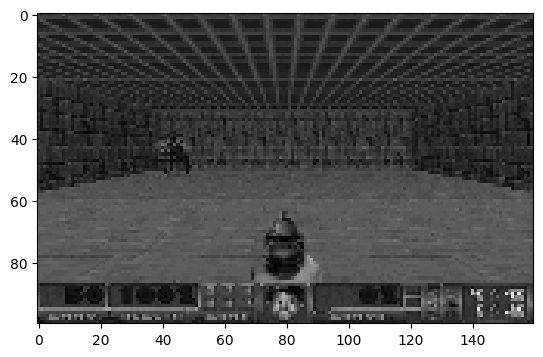

In [115]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

<a name='3.1'></a>
<h3>&sect;3.1: Ontwikkelen Baseline Stategie</h3>

Episode gestart...
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: 100.0
Reward: -1.0
Totale score: 88.0


<a name='3.1'></a>
<h3>&sect;3.2: Implementeren van een Algoritme</h3>

<a name='3.3'></a>
<h3>&sect;3.3: Experimenteren met hyperparameters</h3>

<a name='3.4'></a>
<h3>&sect;3.4: Training</h3>


---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H4: Valideer en Vergelijk </strong></h2>
</div>

<a name='4.1'></a>
<h3>&sect;4.1 Vergelijken met minimaal één baseline</h3>

<a name='4.2'></a>
<h3>&sect;4.2: Analiseren en Visualiseren van Resultaten </h3>


---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H5: Beschrijf je Werk (Rapporteren) </strong></h2>
</div>

<a name='5.1'></a>
<h3>&sect;5.1: Probleemstelling</h3>

<a name='5.2'></a>
<h3>&sect;5.2: Methodologie</h3>

<a name='5.3'></a>
<h3>&sect;5.3: Resultaten</h3>

<a name='5.4'></a>
<h3>&sect;5.4: Reflectie</h3>


---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H6: Literatuurlijst </strong></h2>
</div>


---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H7: Beoordelingscriteria </strong></h2>
</div>

| **Criteria**                | **Level 4 (5p)**                                                                                                                                                       | **Level 3 (3p)**                                                                                                                                                        | **Level 2 (2p)**                                                                                                                                                       | **Level 1 (0p)**                                                                                                      |
|----------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------|
| **Use-case kiezen**        | De gekozen use-case is creatief, de toepassing is realistisch met duidelijke meerwaarde van RL. Overtuigende motivatie voor RL wordt gegeven.                          | De use-case is creatief en geschikt voor RL en het probleem is goed gedefinieerd, maar de argumentatie is beperkt of vergelijkt de RL benadering niet met andere benaderingen. | De use-case is praktisch maar weinig innovatief, of er wordt beperkte analyse van de meerwaarde van RL.                          | Triviale of irrelevante use-case, die niet geschikt is voor RL. Weinig of geen argumentatie gegeven.                 |
| **Begrip van RL**          | Er wordt een uitgebreide uitleg gegeven van het gekozen RL-algoritme.                                                                                                 | Er is sprake van een basiskennis van het RL-algoritme, maar de uitleg is beperkt of niet gedetailleerd genoeg.                                                         | Oppervlakkige uitleg (bv. de agent leert een hogere reward te krijgen) zonder verdere uitwerking. Kleine fouten in de uitleg.    | Volledig verkeerde, onduidelijke of ontbrekende uitleg.                                                              |
| **Implementatie**          | De Python-implementatie werkt volledig zoals verwacht. De agent leert op een slimme en efficiënte manier door de omgeving te navigeren. De simulatie is 100% reproduceerbaar en toont elke keer de verwachte resultaten. | De Python-implementatie werkt voor het grootste gedeelte van de simulatie, maar faalt in bepaalde scenario's of de agent vertoont af en toe onverwacht gedrag, of de simulatie is niet 100% reproduceerbaar. | De Python-implementatie is rommelig en presteert niet zoals verwacht. De agent faalt vaak of vertoont voor het grootste deel onverwacht gedrag, of de simulatie is bijna nooit reproduceerbaar. | De Python-implementatie werkt nauwelijks of helemaal niet.                                                           |
| **Validatie en vergelijking** | De simulatie wordt getest met realistische scenario's en de prestaties worden grondig geanalyseerd. De resultaten van deze analyse worden duidelijk gevisualiseerd. | Er zijn een behoorlijk aantal tests uitgevoerd, maar de testcases zouden uitgebreider kunnen zijn en de analyse van de resultaten zou diepgaander kunnen zijn.           | Er is een zeer beperkt aantal testen uitgevoerd of de resultaten zijn niet op een bevredigend niveau geanalyseerd en gevisualiseerd. | Er is nauwelijks tot geen testing gedaan.                                                                           |
| **Rapporteren**            | Het rapport is helder en goed gestructureerd. De methodologie is goed uitgelegd.                                                                                      | Het rapport is bevredigend, maar het is niet goed gestructureerd en uitgelegd.                                                                                          | Het rapport is rommelig en er ontbreken belangrijke details.                                                                      | Het rapport is onbevredigend, onjuist of afwezig.                                                                    |
